In this notebook we implement a linear regression with regularisation. Regularisation is a method to prevent overfitting by penalising a model with large values of the coefficients of the regression. Roughly speaking, this will prevent the model from training the coefficients to reach the absolute minimum it can find, since this will most likely be incorporating training-data specific idiosyncrasies and/or noise and therefore be overfitting. 

The use of regularisation presents the opportunity for hyperparameter tuning. As part of the procedure, we can choose how much the model is penalised when the coefficients become large. If we add an excessive penalty, then the model could potentially become underfit, whilst too small of a penalty would only be a marginal improvement on our model with no regularisation. In order to find the best parameters, we use a grid seach with cross validation. This takes the training data and performs a train-test split, fits the model according to the training data and the evaluates it according to the test data (of this split). It then does this several times (5 in our case) and averages the scores for that model. This guards against the possibility that our model might perform well when tested purely because we got a train-test-split where the training data doesn't accurately represent data that the model hasn't seen before. 

Moving forward, we will skip the data exploration and visualisation steps since this was completed previously in the BasicLinReg notebook. In this notebook we will also include categorical data. We feel confident in doing this and, therefore, beginning with quite a complex model, since regularisation will cut down the number of features in the model and select the most important ones. 

In [26]:
import numpy as np
import pandas as pd
from math import log
%matplotlib inline 
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')


train_data = pd.read_csv("home-data-for-ml-course/train.csv")
test_data = pd.read_csv("home-data-for-ml-course/test.csv")

pd.set_option('display.max_columns', None)
train_data = train_data.copy()
test_data = test_data.copy()
train_data.set_index('Id')
test_data.set_index('Id'); 

In [27]:
y = train_data.SalePrice
train_data.drop('SalePrice',axis = 1,inplace = True)

In the following, I'll just use all of the features. I believe that part of the point of regularisation is to get rid of correlated features.

In [28]:
categorical_cols = [cname for cname in train_data.columns if train_data[cname].nunique() < 10 and 
                        train_data[cname].dtype == "object"]
numerical_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]

my_cols = categorical_cols + numerical_cols
train_data_prepared = train_data[my_cols].copy()


In [29]:
numerical_transformer = SimpleImputer(strategy = 'median')
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [30]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

model = ElasticNet()
X_train, X_test, y_train, y_test = train_test_split(train_data_prepared, y, train_size = 0.9, random_state = 42)
my_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                              ('std_scaler',StandardScaler()),
                              ('model', model)
                             ])
parameters = {'model__l1_ratio' : np.linspace(0,1,50), 'model__alpha' : np.logspace(-2,0,50)}

gs = GridSearchCV(my_pipeline, param_grid = parameters, scoring = 'neg_mean_squared_error', cv = 5)
gs.fit(X_train, np.log(y_train))


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['Id',
                                                                          'MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          '2ndFlrSF',
                                                                          'LowQualFinSF',
                                                                          'GrLivArea',
                                                                          'BsmtF...
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
             scoring='neg_mean_squared_error')

In [31]:
print(gs.best_params_)
print((-gs.best_score_)**0.5)

{'model__alpha': 0.15264179671752334, 'model__l1_ratio': 0.061224489795918366}
0.151607831624859


These were the values from training previously. It's good that the alpha has gone up -- that will hopefully mean it is less overfit. 

{'model__alpha': 0.15, 'model__l1_ratio': 0.01}
-0.023870733667325617

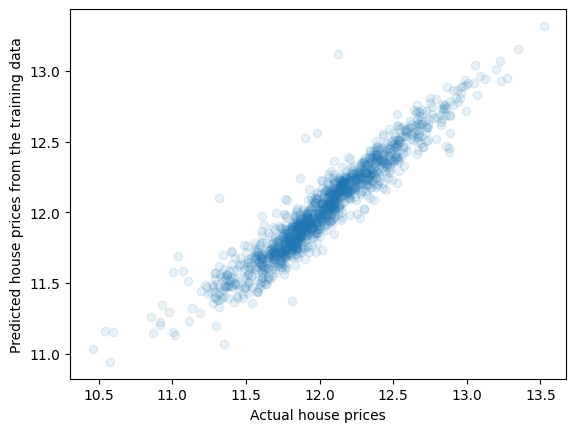

RMSE of the test data is: 0.1227748510673714


In [32]:
best_model = gs.best_estimator_
y_predict = best_model.predict(X_train)
RMSE = mean_squared_error(y_predict, np.log(y_train))**0.5
plt.scatter(np.log(y_train), y_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices from the training data")
plt.show()
print(f"RMSE of the test data is: {RMSE}")

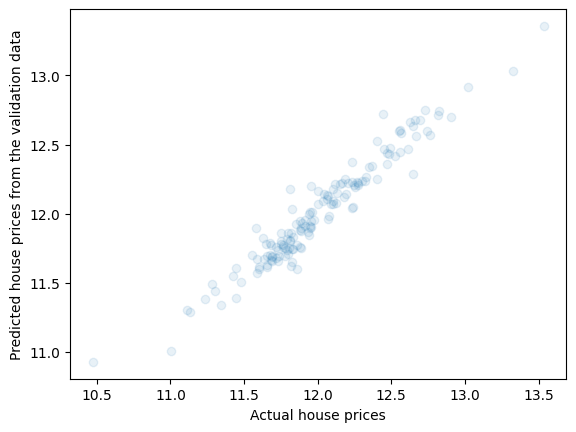

RMSE of the test data is: 0.11573955309468939


In [33]:
y_predict = best_model.predict(X_test)
RMSE = mean_squared_error(y_predict, np.log(y_test))**0.5
plt.scatter(np.log(y_test), y_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices from the validation data")
plt.show()
print(f"RMSE of the test data is: {RMSE}")

Even though the test data is performing better than the training data, this is most likely due to a small testing size. We can see that the RMSE score of the test and training data is significantly less than the RMSE cross validation error, which indicates a fairly strong overfit. 

In any case, it is certainly a significant improvement on the standard linear model. Some ways which we might be able to improve the model are: 
* Many of the categorical variables could be ordinal imputed in a fairly straightforward way. There is a clear heirarchy between, for example, 'Good', 'Typical', etc and we could utilise this to better represent the nature of the categorical variables.
* When imputing the categorical variables, we chose to use 'constant', since the dataset tells us that a missing number means that this feature doesn't exist. We therefore didn't want to lump this in with any other entry for the this feature. It is possible that dropping this data if there are too many missing entries might work better. In particular, if a feature doesn't exist far more often than it does, it's possible (or even likely) that training a model which includes this feature will be overfit.
* As in the linear regression example, we have made no effort to deal with outliers. If we were able to do this effectively, then it might also be feasible to try a min-max scaling too, rather than standardisation.

In [34]:
best_model = gs.best_estimator_
output = np.exp(best_model.predict(test_data))
my_submission = pd.DataFrame({'Id': test_data.Id, 'SalePrice': output})
my_submission.to_csv('ElasticGridSearchCV.csv', index = False)

This got a score of .14204 on the Kaggle submission.